In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

def cartesian_product(*arrays):
    return np.array(np.meshgrid(*arrays)).T.reshape(-1, len(arrays))

def graph(
    x, y=None, u=None, v=None, fn=None, eqn=None,
    xlim=None, ylim=None, title=None,
    fn_params=None, fn_sliders=None, normalize=False,
    show_legend=True, equal_aspect=False,
    **plot_args
):
    '''
    Can graph scatter plots, vector fields, functions f(x),
    implicit equations f(x,y)=g(x,y), and approximate
    binary relations of {(x,y): f(x,y)==True}
    
    Graphing scatter plot requires
        x: numpy.ndarray
        y: numpy.ndarray
        u=None
        v=None
        fn=None
        eqn=None
    
    Graphing vector field requires
        x: numpy.ndarray
        y: numpy.ndarray
        u: function of x, y
        v: function of x, y
        fn=None
        eqn=None
    
    Graphing f(x) requires
        x: numpy.ndarray
        y=None
        u=None
        v=None
        fn: function of x
        eqn=None

    Graphing f(x,y)=g(x,y) requires
        x: numpy.ndarray
        y: numpy.ndarray
        u=None
        v=None
        fn=None
        eqn: {'lhs': f, 'rhs': g}

    Graphing binary relation requires
        x: numpy.ndarray
        y: numpy.ndarray
        u=None
        v=None
        fn: binary relation (boolean function) on x and y
        eqn=None
    
    fn_params (optional): dictionary of numpy.ndarrays
    fn_sliders (optional): list of dictionary parameters:
        {'name', 'min', 'max', 'value'}
    
    functions u, v, fn, eqn['lhs'], eqn['rhs'] should handle additional
    parameters if defined in fn_params and fn_sliders
    '''
    def init(ax):
        if xlim is not None: ax.set_xlim(xlim)
        if ylim is not None: ax.set_ylim(ylim)
        if title is not None: ax.set_title(title)
        ax.grid(True, which='both')
        # set the x-spine (see below for more info on `set_position`)
        ax.spines['left'].set_position('zero')
        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()
        # set the y-spine
        ax.spines['bottom'].set_position('zero')
        # turn off the top spine/ticks
        ax.spines['top'].set_color('none')
        ax.xaxis.tick_bottom()
    
    fig, ax = plt.subplots()
    if equal_aspect: fig.gca().set_aspect('equal', adjustable='box')
    init(ax)
    param_list = []
    plots = []
    MODE_SCATTER, MODE_VECTOR, MODE_FN, MODE_IMPLICIT, MODE_RELATION = 1, 2, 3, 4, 5
    if u is None and v is None and fn is None and eqn is None: mode = MODE_SCATTER
    elif fn is None and eqn is None: mode = MODE_VECTOR
    elif y is None and u is None and v is None and eqn is None: mode = MODE_FN
    elif u is None and v is None and fn is None: mode = MODE_IMPLICIT
    elif u is None and v is None and eqn is None: mode = MODE_RELATION
    else: raise Exception(
        'invalid operating mode, see parameter requirements'
    )
    if mode == MODE_SCATTER:
        plot, = ax.plot(x, y, '.')
        return
    elif mode == MODE_VECTOR:
        X, Y = np.meshgrid(x, y)
    elif mode == MODE_IMPLICIT:
        X, Y = np.meshgrid(x, y)
        lhs, rhs = eqn['lhs'], eqn['rhs']
    elif mode == MODE_RELATION: domain = cartesian_product(x, y)

    if fn_sliders is None: args = {}
    else: args = {slider['name']: slider['value'] for slider in fn_sliders}
    if fn_params is None:
        param_list = [{}]
        if mode == MODE_FN: plot, = ax.plot(x, fn(x, **args), '-', **plot_args)
        elif mode == MODE_VECTOR:
            U, V = u(X, Y, **args), v(X, Y, **args)
            if normalize:
                N = np.sqrt(U**2 + V**2)
                U, V = U/N, V/N
            plot = ax.quiver(X, Y, U, V, **plot_args)
        elif mode == MODE_IMPLICIT: plot = ax.contour(
            X, Y, lhs(X, Y, **args) - rhs(X, Y, **args), [0]
        )
        elif mode == MODE_RELATION:
            x_data, y_data = [], []
            for pt in domain:
                if fn(x=pt[0], y=pt[1], **args):
                    x_data.append(pt[0])
                    y_data.append(pt[1])
            plot, = ax.plot(x_data, y_data, '.', **plot_args)
        plots.append(plot)
    else:
        if len(fn_params) == 1:
            k = list(fn_params.keys())[0]
            param_list = [{k: v} for v in fn_params[k]]
        else:
            param_space = cartesian_product(*[v for k, v in fn_params.items()])
            for row in param_space:
                params = {}
                for k, v in zip(fn_params, row):
                    params[k] = v
                param_list.append(params)
        for params in param_list:
            label = ""
            for k, v in params.items():
                label += str(k) + '=' + str(v) + ','
            if mode == MODE_FN: plot, = ax.plot(
                x, fn(x, **params, **args), '-', label=label, **plot_args
            )
            # no vector field support for params for now
            elif mode == MODE_IMPLICIT: plot = ax.contour(
                X, Y, lhs(X, Y, **params, **args)-rhs(X, Y, **params, **args), [0]
            )
            elif mode == MODE_RELATION:
                x_data, y_data = [], []
                for pt in domain:
                    if fn(x=pt[0], y=pt[1], **params, **args):
                        x_data.append(pt[0])
                        y_data.append(pt[1])
                plot, = ax.plot(x_data, y_data, '.', label=label, **plot_args)
            plots.append(plot)
        if show_legend: ax.legend()

    if fn_sliders is not None:
        plt.subplots_adjust(bottom=len(fn_sliders)*0.06)
        sliders = {}
        for i, s in enumerate(fn_sliders):
            axis = plt.axes([0.2, i*0.05+0.01, 0.5, 0.03])
            sliders[s['name']] = Slider(
                axis, s['name'], s['min'], s['max'], s['value'],
                valstep=0.01*(s['max']-s['min'])
            )

        def update(val):
            for k, slider in sliders.items():
                args[k] = slider.val
            if mode == MODE_FN:
                for i, params in enumerate(param_list):
                    plots[i].set_ydata(fn(x, **params, **args))
            elif mode == MODE_VECTOR:
                U, V = u(X, Y, **args), v(X, Y, **args)
                if normalize:
                    N = np.sqrt(U**2 + V**2)
                    U, V = U/N, V/N
                plots[0].set_UVC(U, V)
            elif mode == MODE_IMPLICIT:
                ax.clear()
                init(ax)
                for i, params in enumerate(param_list):
                    contour = ax.contour(
                        X, Y,
                        lhs(X, Y, **params, **args)-rhs(X, Y, **params, **args),
                        [0]
                    )
            elif mode == MODE_RELATION:
                for i, params in enumerate(param_list):
                    x_data, y_data = [], []
                    for pt in domain:
                        if fn(x=pt[0], y=pt[1], **params, **args):
                            x_data.append(pt[0])
                            y_data.append(pt[1])
                    plots[i].set_xdata(x_data)
                    plots[i].set_ydata(y_data)
            fig.canvas.draw_idle()

        for k, slider in sliders.items():
            slider.on_changed(update)
        return sliders # need sliders in global scope to receive updates

<IPython.core.display.Javascript object>


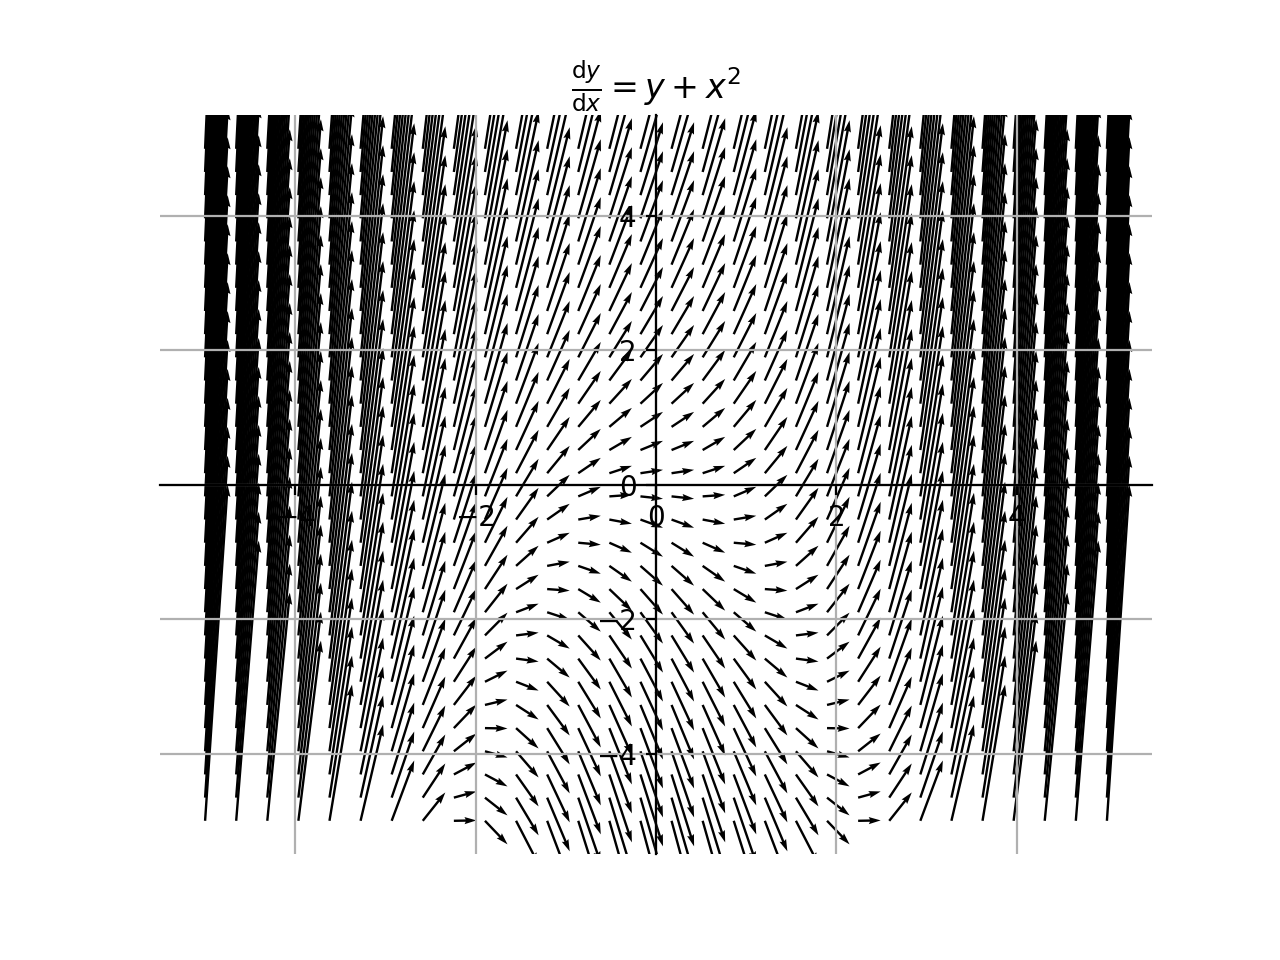

In [22]:
graph(
    x=np.linspace(-5, 5, 30),
    y=np.linspace(-5, 5, 30),
    u=lambda x, y: np.ones(x.size).reshape(x.shape),
    v=lambda x, y: y+x**2,
    title=r'$\frac{\mathrm{d}y}{\mathrm{d}x}=y+x^2$',
    angles='xy', scale_units='xy', scale=4
)

<IPython.core.display.Javascript object>


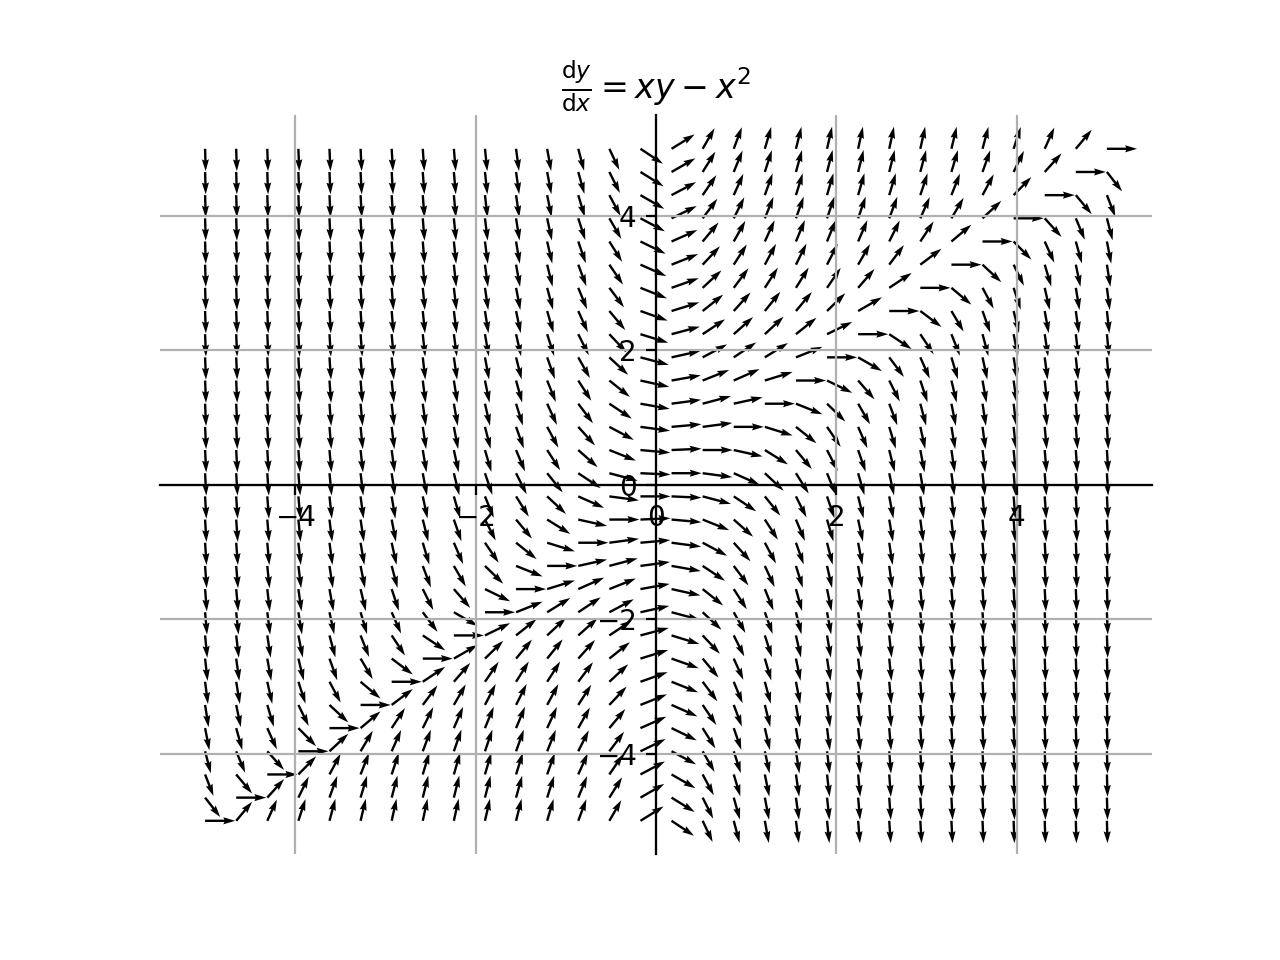

In [27]:
graph(
    x=np.linspace(-5, 5, 30),
    y=np.linspace(-5, 5, 30),
    u=lambda x, y: np.ones(x.size).reshape(x.shape),
    v=lambda x, y: x*y-x**2,
    normalize=True,
    title=r'$\frac{\mathrm{d}y}{\mathrm{d}x}=xy-x^2$',
    angles='xy', scale_units='xy', scale=3
)

<IPython.core.display.Javascript object>


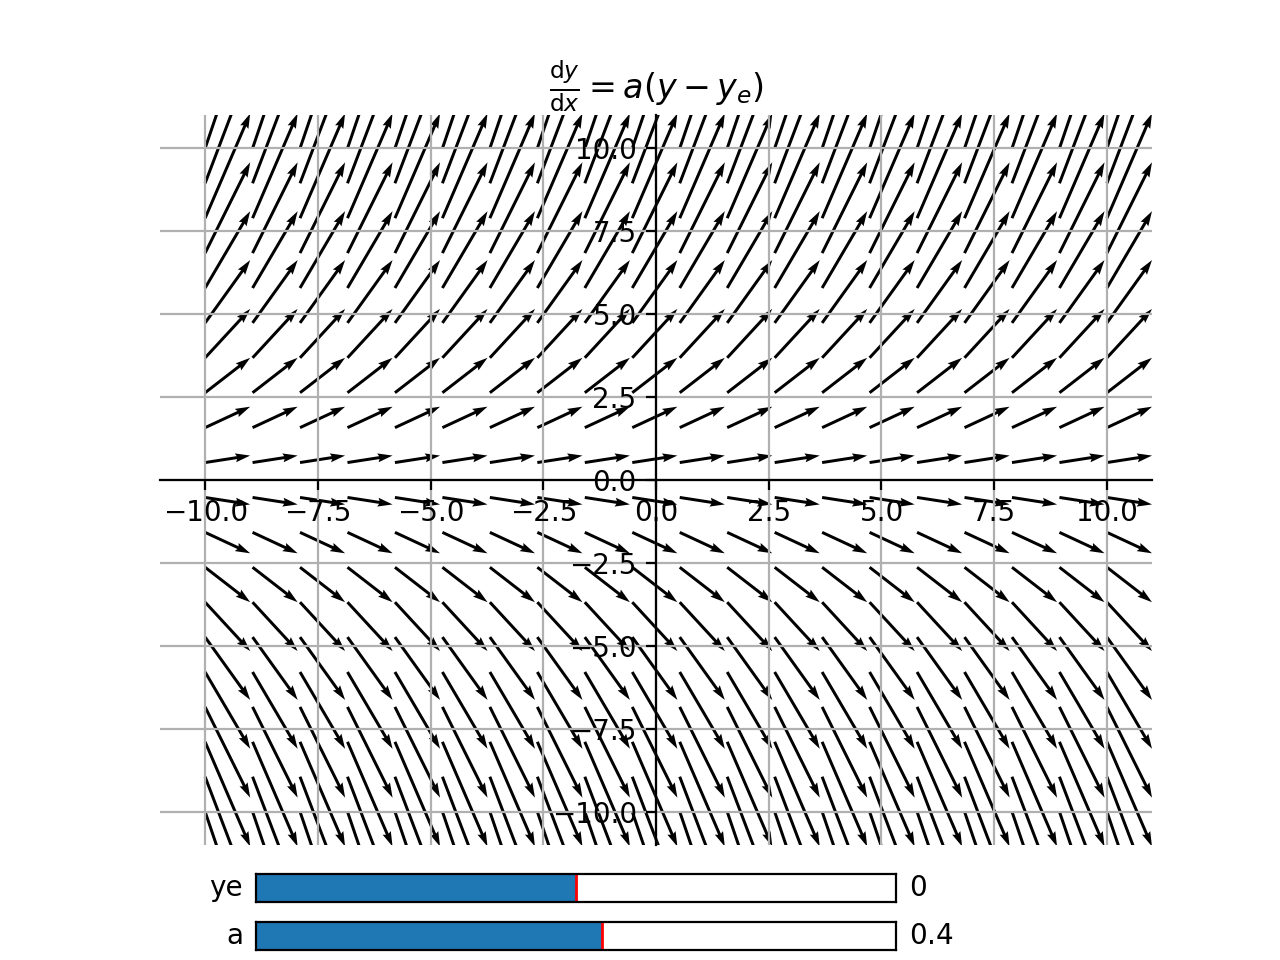

{'a': <matplotlib.widgets.Slider at 0x7fb19796a7f0>,
 'ye': <matplotlib.widgets.Slider at 0x7fb1979a46a0>}

In [3]:
graph(
    x=np.linspace(-10, 10, 20),
    y=np.linspace(-10, 10, 20),
    u=lambda x, y, a, ye: np.ones(x.size).reshape(x.shape),
    v=lambda x, y, a, ye: a*(y-ye),
    title=r'$\frac{\mathrm{d}y}{\mathrm{d}x}=a(y-y_e)$',
    fn_sliders=[
        {'name': 'a', 'min': -5, 'max': 5, 'value': 0.4},
        {'name': 'ye', 'min': -5, 'max': 5, 'value': 0}
    ],
    angles='xy', scale_units='xy', scale=1
)

<IPython.core.display.Javascript object>


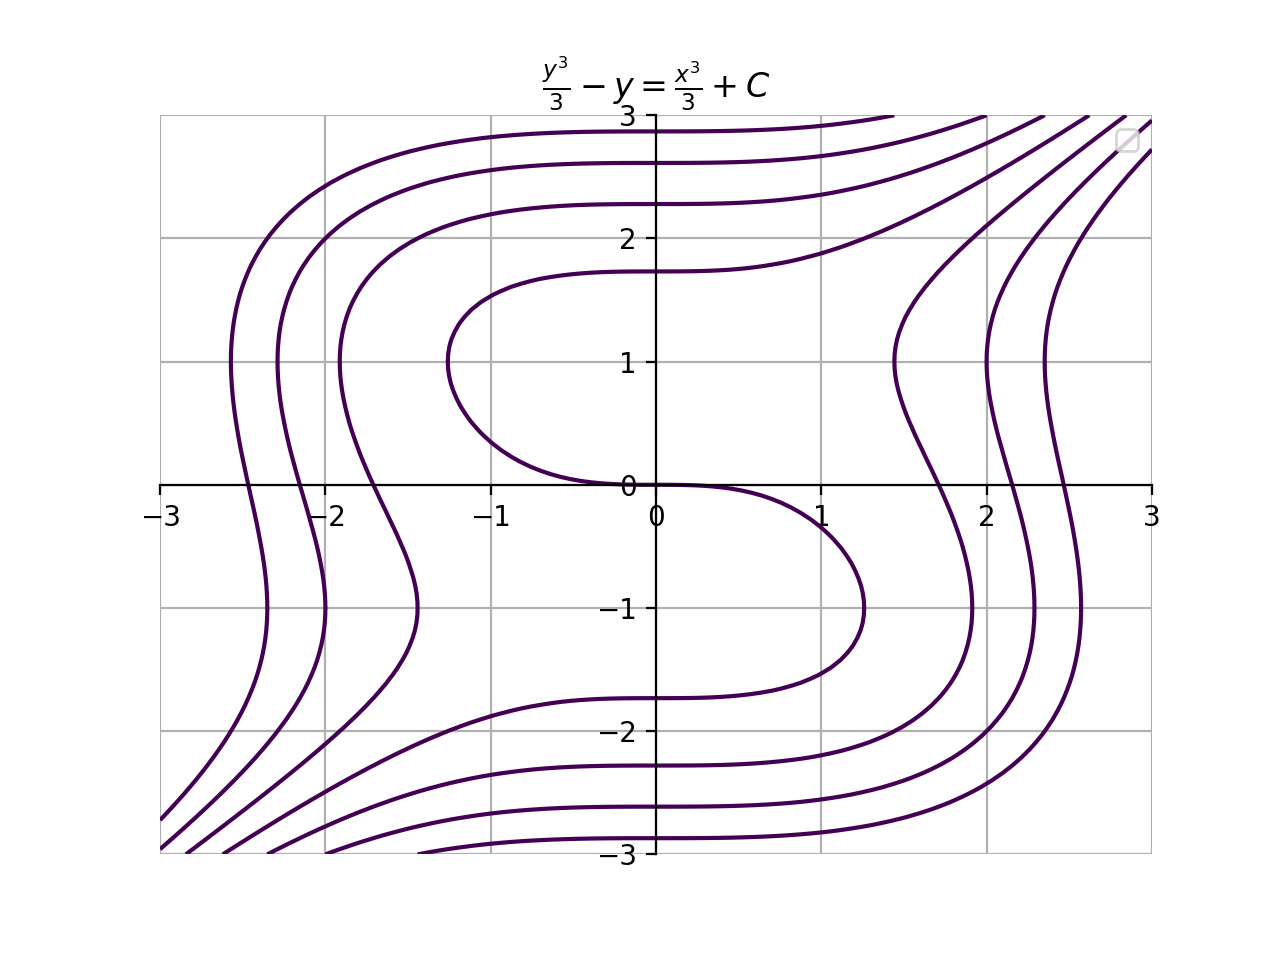

No handles with labels found to put in legend.


In [4]:
graph(
    x=np.linspace(-3, 3, 100),
    y=np.linspace(-3, 3, 100),
    eqn={'lhs': lambda x, y, C: y**3/3-y, 'rhs': lambda x, y, C: x**3/3+C},
    title=r'$\frac{y^3}{3}-y=\frac{x^3}{3}+C$',
    fn_params={'C': np.linspace(-5, 5, 7)}
)

<IPython.core.display.Javascript object>


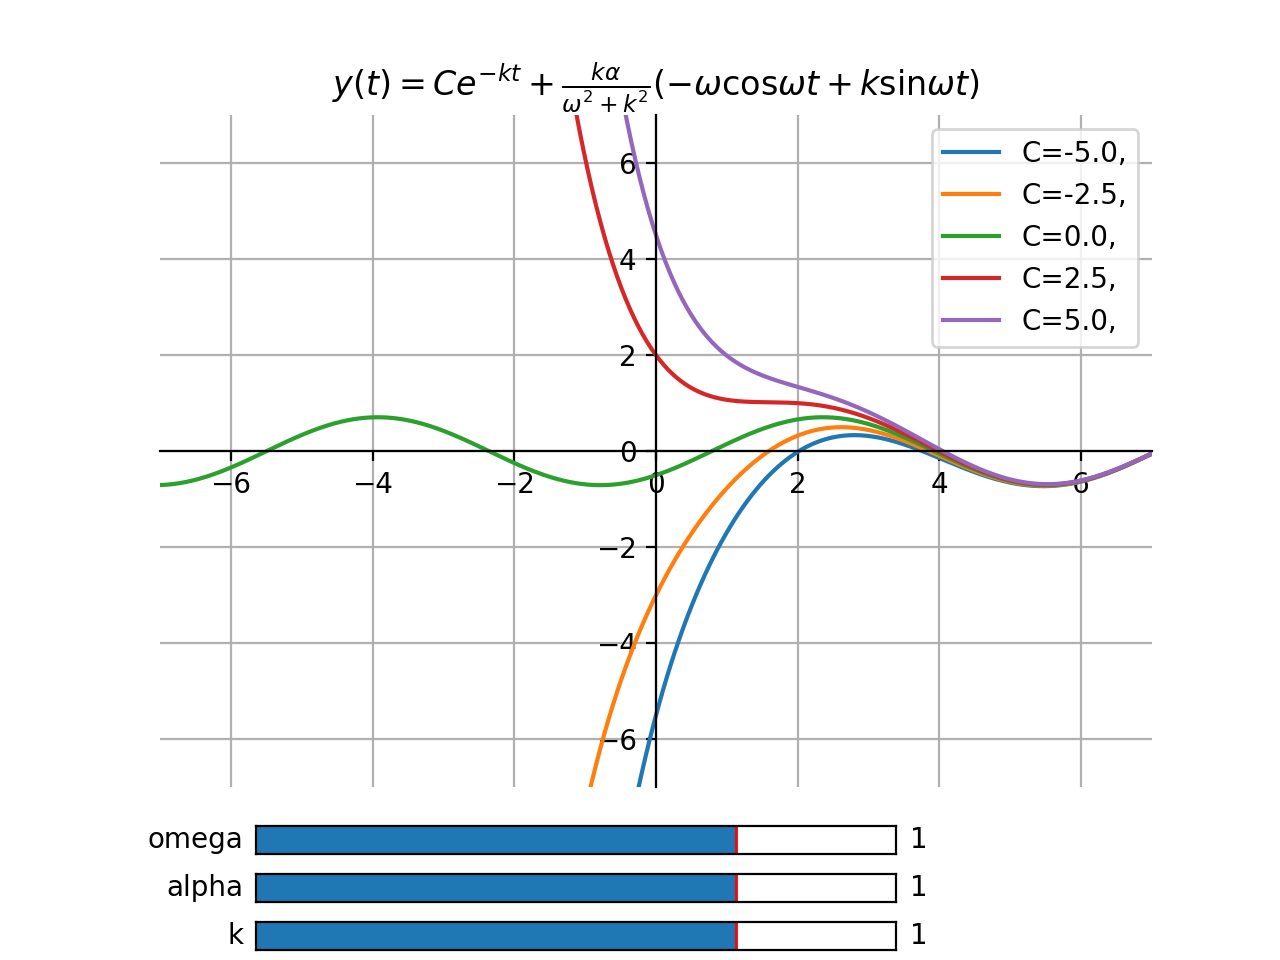

{'k': <matplotlib.widgets.Slider at 0x7fb1944df6d0>,
 'alpha': <matplotlib.widgets.Slider at 0x7fb194519a00>,
 'omega': <matplotlib.widgets.Slider at 0x7fb194553ac0>}

In [5]:
graph(
    x=np.linspace(-10, 10, 1000),
    fn=lambda x, C, k, alpha, omega: C*np.exp(-k*x)+k*alpha/(omega**2+k**2)*(-omega*np.cos(omega*x)+k*np.sin(omega*x)),
    xlim=(-7, 7), ylim=(-7, 7),
    title=r'$y(t)=Ce^{-kt}+\frac{k\alpha}{\omega^2+k^2}(-\omega\cos{\omega t}+k\sin{\omega t})$',
    fn_params={'C': np.linspace(-5, 5, 5)},
    fn_sliders=[
        {'name': 'k', 'min': -2, 'max': 2, 'value': 1},
        {'name': 'alpha', 'min': -2, 'max': 2, 'value': 1},
        {'name': 'omega', 'min': -2, 'max': 2, 'value': 1}
    ]
)

<IPython.core.display.Javascript object>


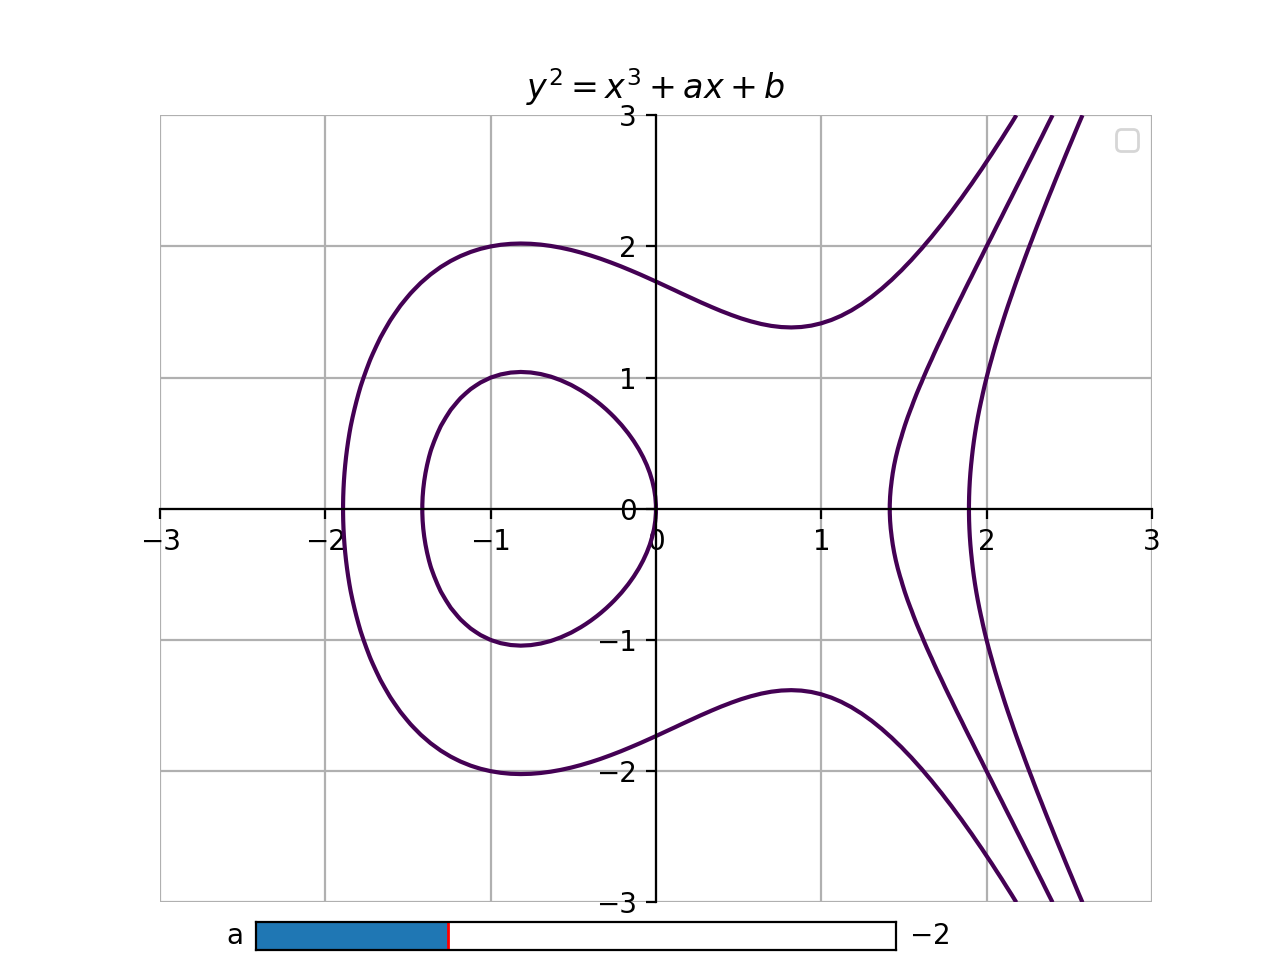

No handles with labels found to put in legend.


{'a': <matplotlib.widgets.Slider at 0x7fb1945ddf10>}

In [6]:
graph(
    x=np.linspace(-3, 3, 100),
    y=np.linspace(-3, 3, 100),
    eqn={
        'lhs': lambda x, y, a, b: y**2,
        'rhs': lambda x, y, a, b: x**3+a*x+b
    },
    xlim=(-3, 3), ylim=(-3, 3),
    title=r'$y^2=x^3+ax+b$',
    fn_params={'b': np.linspace(-3, 3, 3)},
    fn_sliders=[
        {'name': 'a', 'min': -5, 'max': 5, 'value': -2}
    ]
)

<IPython.core.display.Javascript object>


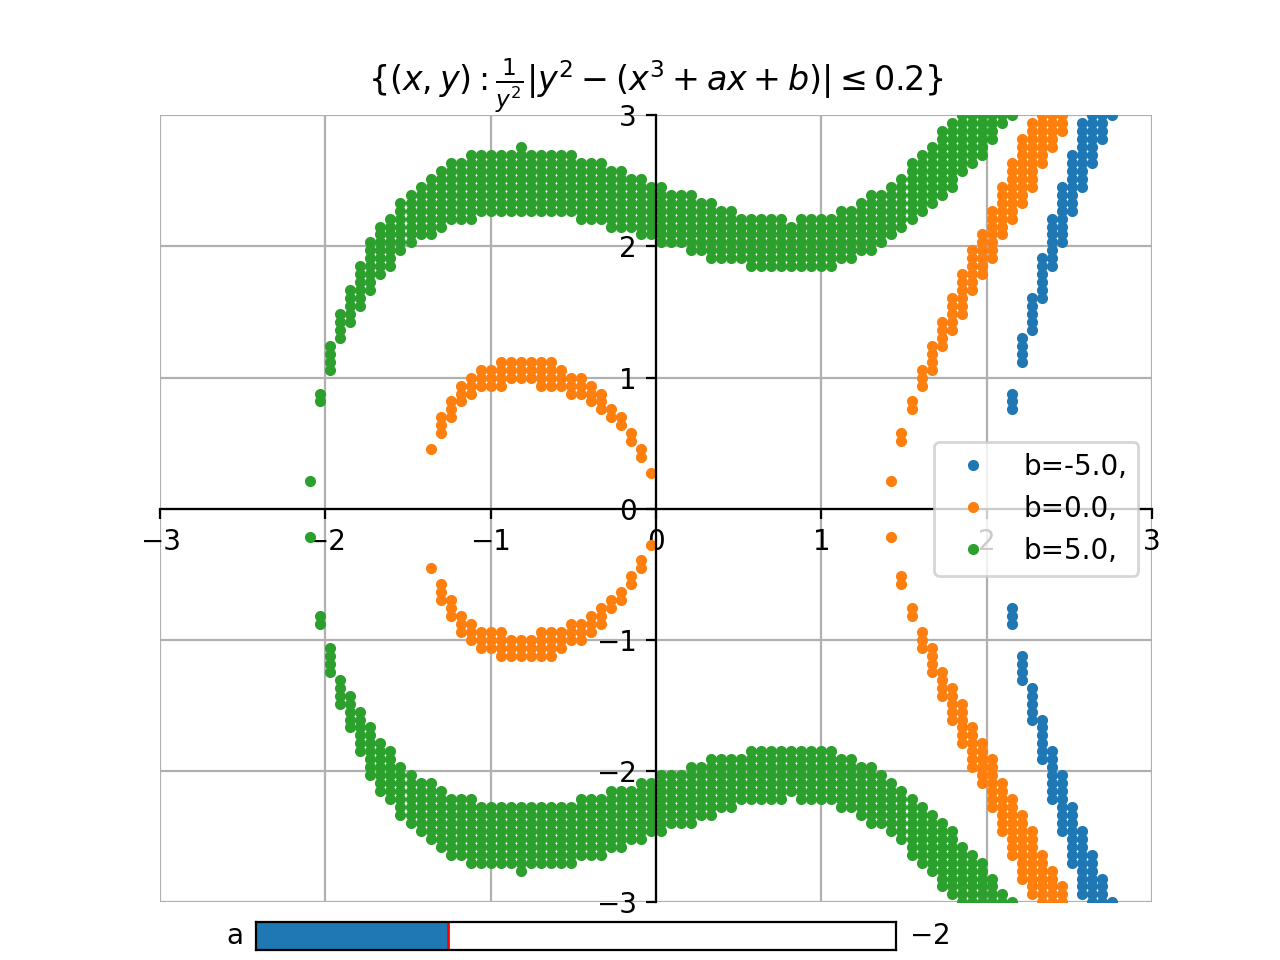

{'a': <matplotlib.widgets.Slider at 0x7fb197b2cfa0>}

In [7]:
graph(
    x=np.linspace(-3, 3, 100),
    y=np.linspace(-3, 3, 100),
    fn=lambda x, y, a, b: np.isclose(x**3+a*x+b, y**2, rtol=0.2),
    xlim=(-3, 3), ylim=(-3, 3),
    title=r'$\{(x,y):\frac{1}{y^2}|y^2-(x^3+ax+b)|\leq0.2\}$',
    fn_params={'b': np.linspace(-5, 5, 3)},
    fn_sliders=[
        {'name': 'a', 'min': -5, 'max': 5, 'value': -2},
    ]
)

<IPython.core.display.Javascript object>


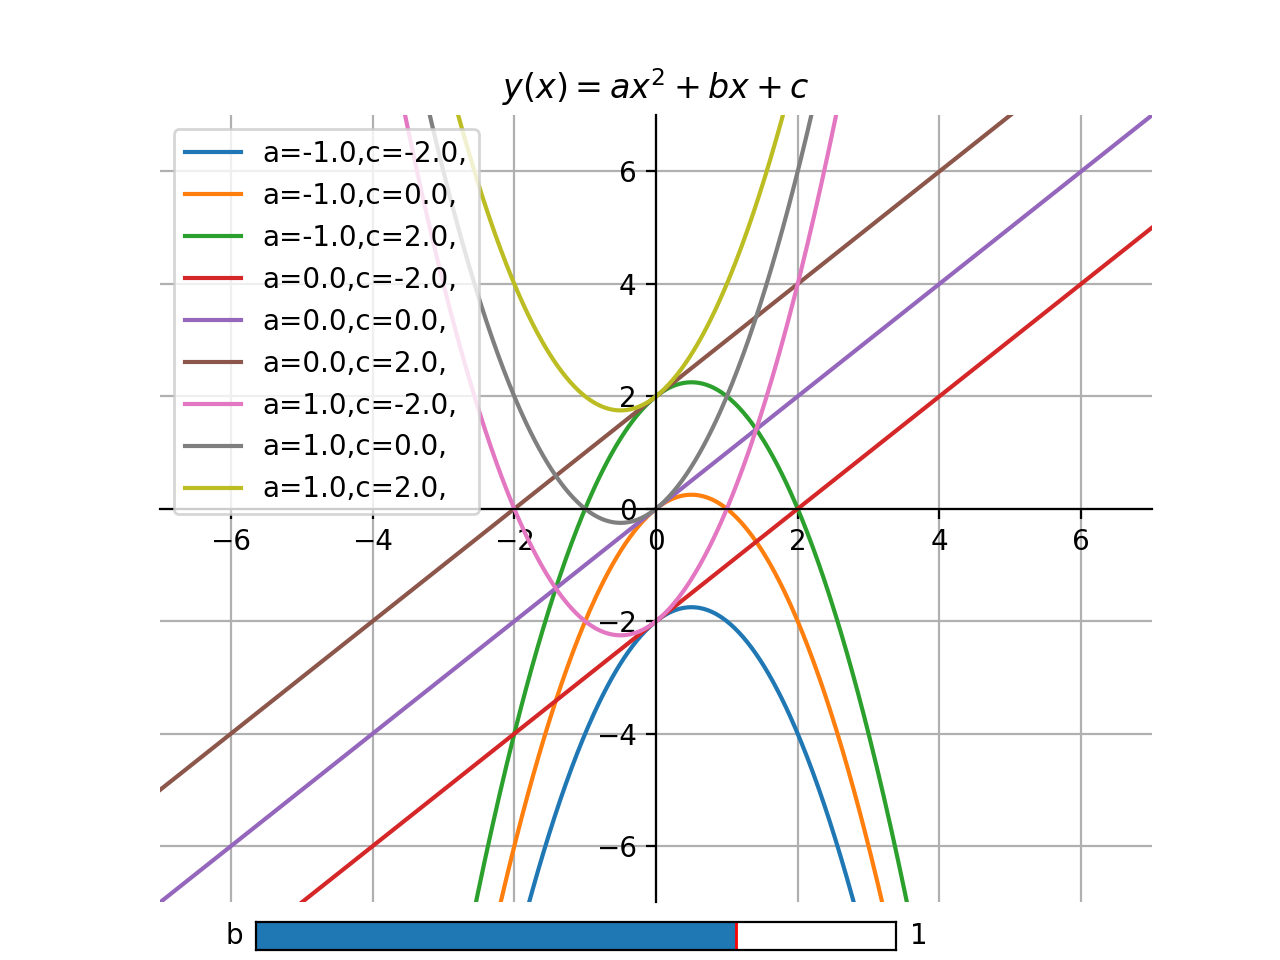

{'b': <matplotlib.widgets.Slider at 0x7fb197bd2730>}

In [8]:
graph(
    x=np.linspace(-10, 10, 1000),
    fn=lambda x, a, b, c: a*x**2+b*x+c,
    xlim=(-7, 7), ylim=(-7, 7),
    title=r'$y(x)=ax^2+bx+c$',
    fn_params={
        'a': np.linspace(-1, 1, 3),
        'c': np.linspace(-2, 2, 3),
    },
    fn_sliders=[{'name': 'b', 'min': -2, 'max': 2, 'value': 1}]
)

<IPython.core.display.Javascript object>


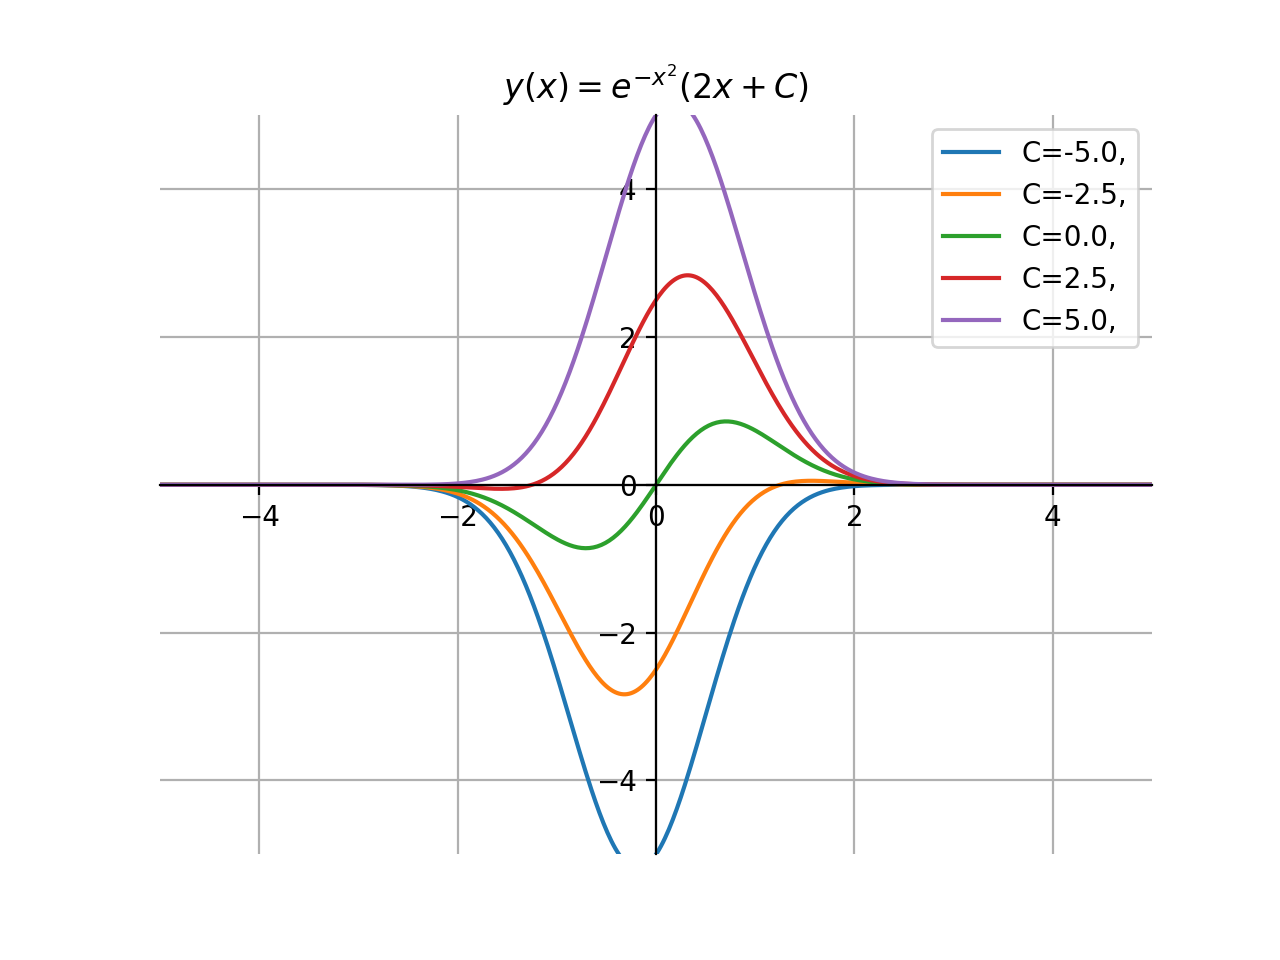

In [9]:
graph(
    x=np.linspace(-10, 10, 1000),
    fn=lambda x, C: (2*x+C) * np.exp(-(x**2)),
    xlim=(-5, 5), ylim=(-5, 5),
    title=r'$y(x)=e^{-x^2}(2x+C)$',
    fn_params={'C': np.linspace(-5, 5, 5)}
)

<IPython.core.display.Javascript object>


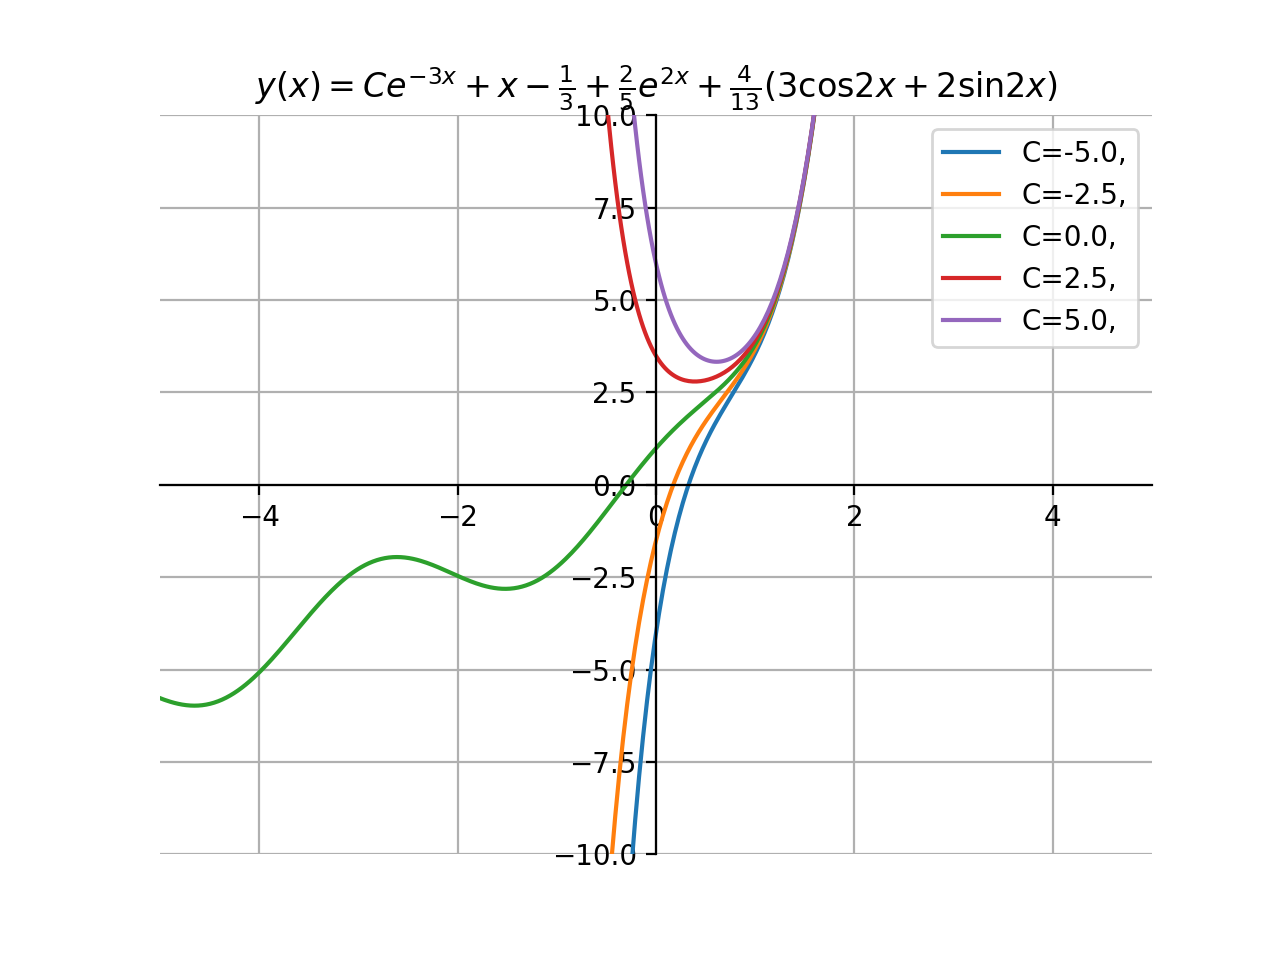

In [10]:
graph(
    x=np.linspace(-10, 10, 1000),
    fn=lambda x, C: C*np.exp(-3*x)+x-1/3+2/5*np.exp(2*x)+4/13*(3*np.cos(2*x)+2*np.sin(2*x)),
    xlim=(-5, 5), ylim=(-10, 10),
    title=r'$y(x)=Ce^{-3x}+x-\frac{1}{3}+\frac{2}{5}e^{2x}+\frac{4}{13}(3\cos{2x}+2\sin{2x})$',
    fn_params={'C': np.linspace(-5, 5, 5)}
)